Observed market data of implied volatilities (IV)
    Strikes    IV
0      1000  0.35
1      1100  0.34
2      1200  0.33
3      1300  0.31
4      1400  0.29
5      1500  0.28
6      1600  0.26
7      1700  0.24
8      1800  0.23
9      1900  0.21
10     2000  0.19
11     2100  0.18
12     2200  0.16
13     2300  0.15
14     2400  0.13
15     2500  0.12
16     2600  0.10
17     2700  0.08
18     2800  0.07
19     2900  0.05


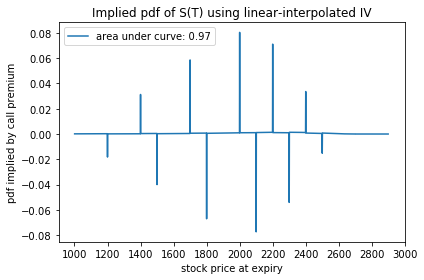

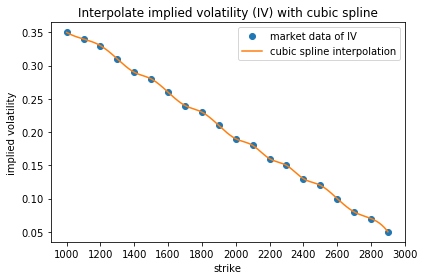

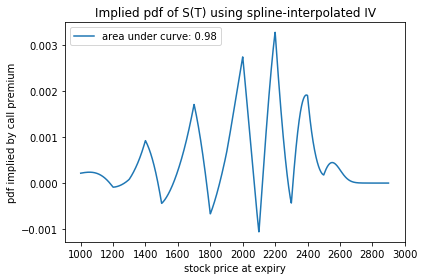

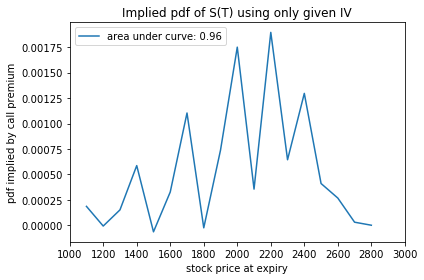

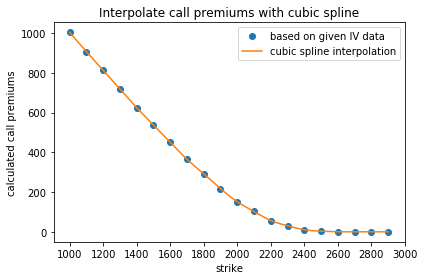

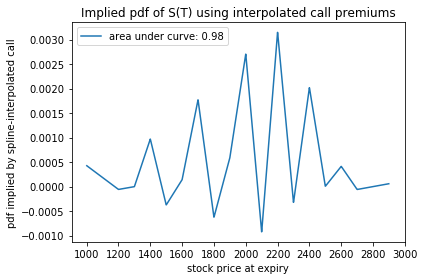

In [3]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import CubicSpline, interp1d
import matplotlib.pyplot as plt

############################################################
# Simple data input
############################################################
strikes = np.array(range(1000,3000,100))
iv = [0.05, 0.07, 0.08, 0.1, 0.12, 0.13, 0.15, 0.16, 0.18, 0.19, 
      0.21, 0.23, 0.24, 0.26, 0.28, 0.29, 0.31, 0.33, 0.34, 0.35]
iv = np.array(list(reversed(iv)))
df_data = pd.DataFrame(list(zip(strikes,iv)), columns=['Strikes', 'IV'])
print('Observed market data of implied volatilities (IV)')
print(df_data)

# helper function to calculate European option price
def option_price(sig, k, is_call):
    ''' Calculate option price under given assumptions. 
    Assume zero risk free rate and dividend. F = 2000, T = 1 year 
    Args:
        sig (float): the implied volatility corresponding to strike k
        k (float): the strike price
        is_call (boolean): for simplicity, True for call and False for put
    Returns:
        float: the European option price with expiry of 1 year
    '''
    f, T = 2000, 1
    d1 = (math.log(f/k) + 0.5 * sig**2 * T) / (sig * T**0.5)
    d2 = d1 - sig * T**0.5
    if is_call:
        price = f * norm.cdf(d1) - k * norm.cdf(d2)
    else:
        price = k * norm.cdf(-d2) - f * norm.cdf(-d1)
    return price

############################################################
# Interpolate implied volatility with piecewise linear func 
############################################################
k_range = np.arange(1000,2901,1)
iv_linear_interpolator = interp1d(strikes, iv, kind='linear')
linear_interp_iv = iv_linear_interpolator(k_range)
call_prices = [option_price(vol, k, is_call=True) 
               for vol, k in zip(linear_interp_iv, k_range)]
# in this FDM differentiation scheme, step size h=1
linear_implied_pdf = [call_prices[i+1] - 2 * call_prices[i] + call_prices[i-1] 
                      for i in range(1, len(call_prices)-1)]
# double check the integrated area under the pdf curve
curve_integral = np.trapz(linear_implied_pdf, x=k_range[1:-1])
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(k_range[1:-1], linear_implied_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by call premium')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using linear-interpolated IV')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pdf with linear-interpolated iv')

############################################################
# Interpolate implied volatility with cubic spline
############################################################
iv_spline_interpolator = CubicSpline(strikes, iv)
cs_interp_iv = iv_spline_interpolator(k_range)
plt.figure()
plt.plot(strikes, iv, 'o', label='market data of IV')
plt.plot(k_range, cs_interp_iv, label='cubic spline interpolation')
plt.xlabel('strike')
plt.ylabel('implied volatility')
plt.xticks(range(1000,3200,200))
plt.title('Interpolate implied volatility (IV) with cubic spline')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('cubic spline implied vol')

############################################################
# Use spline-interpolated IV to calculate call price C
# then differentiate C twice for risk neutral pdf
############################################################
call_prices = [option_price(vol, k, is_call=True)
               for vol, k in zip(cs_interp_iv, k_range)]
cs_iv_implied_pdf = [call_prices[i+1] - 2 * call_prices[i] + call_prices[i-1] 
                  for i in range(1, len(call_prices)-1)]
curve_integral = np.trapz(cs_iv_implied_pdf, x=k_range[1:-1])
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(k_range[1:-1], cs_iv_implied_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by call premium')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using spline-interpolated IV')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pdf with spline-interpolated iv')

############################################################ 
# directly use given IV to calculate call prices C
# then twice differentiate C with large step h
# the error in this numerical differentiation is high
# but we include only for completeness
############################################################
call_prices = [option_price(vol, k, is_call=True)
               for vol, k in zip(iv, strikes)]
sparse_pdf = [(call_prices[i+1] - 2 * call_prices[i] + call_prices[i-1]) / ((strikes[i+1] - strikes[i])**2)
              for i in range(1, len(call_prices)-1)]
curve_integral = np.trapz(sparse_pdf, x=strikes[1:-1])
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(strikes[1:-1], sparse_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by call premium')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using only given IV')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pdf with only given iv')

############################################################
# use given IV to calculate C 
# then interpolate C with cubic spline and take derivative
############################################################
given_calls = [option_price(vol, k, is_call=True)
               for vol, k in zip(iv, strikes)]
c_spline_interpolator = CubicSpline(strikes, given_calls)
call_prices = c_spline_interpolator(k_range)
# plot the cubic spline interpolation of call premiums
plt.figure()
plt.plot(strikes, given_calls, 'o', label='based on given IV data')
plt.plot(k_range, call_prices, label='cubic spline interpolation')
plt.xlabel('strike')
plt.ylabel('calculated call premiums')
plt.xticks(range(1000,3200,200))
plt.title('Interpolate call premiums with cubic spline')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('cubic spline call premium')
# now numerically differentiate with FDM step h=1
cs_call_implied_pdf = [call_prices[i+1] - 2 * call_prices[i] + call_prices[i-1] 
                       for i in range(1, len(call_prices)-1)]
curve_integral = np.trapz(cs_call_implied_pdf, x=k_range[1:-1])
label = 'area under curve: {:.2f}'.format(curve_integral)
plt.figure()
plt.plot(k_range[1:-1], cs_call_implied_pdf, label=label)
plt.xlabel('stock price at expiry')
plt.ylabel('pdf implied by spline-interpolated call')
plt.xticks(range(1000,3200,200))
plt.title('Implied pdf of S(T) using interpolated call premiums')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('pdf with interpolated call premiums')